In [ ]:
import torch
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!unzip '/content/dog_vs_cat_classification_v1.zip'

Archive:  /content/dog_vs_cat_classification_v1.zip
   creating: dog_vs_cat_classification_v1/
   creating: dog_vs_cat_classification_v1/test/
   creating: dog_vs_cat_classification_v1/test/cat/
  inflating: dog_vs_cat_classification_v1/test/cat/7954.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7955.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7956.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7957.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7958.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7959.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/796.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7960.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7961.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7962.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7963.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7964.jpg  
  inflating: dog_vs_cat_classification_v1/test/cat/7965.jpg  


In [21]:
class ImageDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    self.image_dir = image_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []
    self.class_name = {}

    # Define allowed image extensions
    self.allowed_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp')

    for label, class_dir in enumerate(os.listdir(image_dir)):
      class_path = os.path.join(image_dir, class_dir)
      if not os.path.isdir(class_path):
        continue # Skip if it's not a directory

      self.class_name[label] = class_dir
      for img_name in os.listdir(class_path):
        if img_name.lower().endswith(self.allowed_extensions): # Check file extension
          self.image_paths.append(os.path.join(class_path, img_name))
          self.labels.append(label)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths[idx]
    image = Image.open(img_path).convert('RGB')
    label = self.labels[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [22]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [23]:
train_image_dir = '/content/dog_vs_cat_classification_v1/train'
test_image_dir = '/content/dog_vs_cat_classification_v1/test'

train_image_dataset = ImageDataset(image_dir=train_image_dir, transform=transform)
test_image_dataset = ImageDataset(image_dir=test_image_dir, transform=transform)

In [24]:
train_image_loader = DataLoader(dataset=train_image_dataset, batch_size=32, shuffle=True)
test_image_loader = DataLoader(dataset=test_image_dataset, batch_size=32, shuffle=True)

In [25]:
print(train_image_dataset.class_name)

{0: 'dog', 1: 'cat'}


torch.Size([32, 3, 128, 128]) torch.Size([32])
(3, 128, 128)
0
dog
(128, 128, 3)


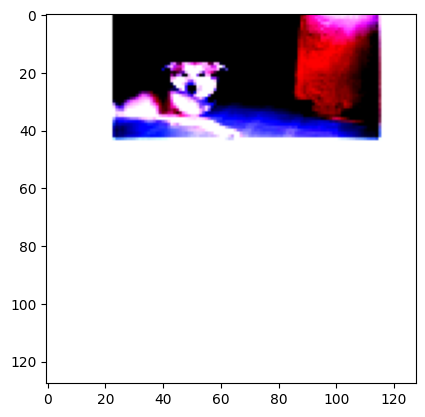

In [26]:
for images, labels in train_image_loader:
  print(images.shape, labels.shape)
  img = images[0].numpy()
  print(img.shape)
  label = labels[0].item()
  print(label)
  print(train_image_dataset.class_name[label])
  img = np.transpose(img, (1,2,0))
  print(img.shape)
  plt.imshow(img, vmin=0, vmax=255)
  break

In [27]:
import torch.nn as nn
import torch.optim as optim

In [28]:
class CustomCnnModel(nn.Module):
  def __init__(self, input_dim, num_classes):
    super(CustomCnnModel, self).__init__()
    self.input_dim = input_dim
    self.num_classes = num_classes

    self.conv_layers = nn.Sequential(
        #C1
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #C2
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #C3
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        #C4
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.to_linear = None
    self.get_conv_output(self.input_dim)

    self.fc_layers = nn.Sequential(
        nn.Linear(self.to_linear, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, self.num_classes)
    )

  def get_conv_output(self, input_dim=128):
    with torch.no_grad():
      dummy_input = torch.zeros(1, 3, input_dim, input_dim)
      output = self.conv_layers(dummy_input)
      self.to_linear = output.view(1, -1).size(1)

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fc_layers(x)
    return x

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCnnModel(input_dim=128, num_classes=2).to(device)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
#Training Loop

epochs = 2
for k in range(epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_image_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f"Epoch {k+1}/{epochs}, Loss: {running_loss/len(train_image_loader)}")

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1/2, Loss: 0.5269006162504607
Epoch 2/2, Loss: 0.47717663381673114


In [41]:
torch.save(model.state_dict(), 'custom_cnn_model.pth')

In [42]:
# Evaluate Model

model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_image_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 72.125%


In [43]:
import cv2

In [44]:
class ImageClassifier:
  def __init__(self, model_path, class_names):
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.model = CustomCnnModel(input_dim=128, num_classes=2).to(self.device)
    self.model.load_state_dict(torch.load(model_path, map_location=self.device))
    self.model.eval()
    self.class_name = class_names
    self.transform = transforms.Compose([
      transforms.Resize((128,128)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  def predict(self, image_path):
    image = Image.open(image_path).convert('RGB')
    image_tensor = self.transform(image).unsqueeze(0).to(self.device)
    with torch.no_grad():
      output = self.model(image_tensor)
      _, predicted = torch.max(output, 1)

    label = self.class_name[predicted.item()]

    # For displaying the image with prediction in Colab, we use matplotlib instead of cv2.imshow
    # Load the image again for display purposes (or use the one already loaded)
    img_to_display = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(6,6))
    plt.imshow(img_to_display)
    plt.title(f"Predicted: {label}")
    plt.axis('off') # Hide axes ticks
    plt.show()

    return label

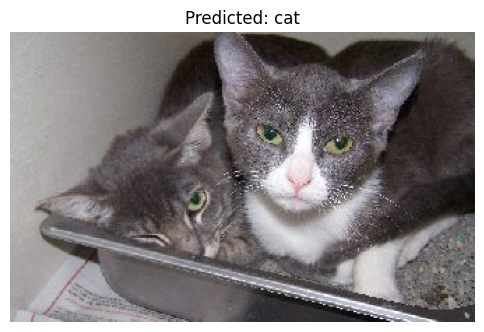

This is a: cat


In [46]:
classifier = ImageClassifier("/content/custom_cnn_model.pth", train_image_dataset.class_name)
label = classifier.predict("/content/dog_vs_cat_classification_v1/test/cat/7954.jpg")
print(f"This is a: {label}")